In [ ]:
# imports
import os

import torch
from torch import Tensor
from PIL.Image import Image
import matplotlib.pyplot as plt
import trimesh

from v_prism.utils.ui import abspath, mkdir_if_not_exists
from v_prism.data_loading.bullet_reconstruction_dataset import ReconBulletDataset
from v_prism.utils.pointsdf import PointSDF, scale_and_center_object_points
from v_prism.utils.pointsdf import scale_and_center_queries, index_points
from v_prism.utils.pointsdf import  farthest_point_sample
from v_prism.data_loading.scene import Scene
from v_prism.utils.visualization import gen_image_of_trimesh_scene, gen_mesh_for_sdf_batch_3d
from v_prism.utils.subsample import grid_subsample


In [38]:
# global vars

model_name = "pointsdf.pt"
# dataset_name = "shapenet_train_2000"
dataset_name = "bhm4recon_shapenet_100"


# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

print(f"using device {device}!")
data_dir = abspath("~/data")
logs_dir = abspath("~/projects/bhm4reconstruction/logs")
mkdir_if_not_exists(os.path.join(logs_dir, "models"))
model_path = abspath(os.path.join(logs_dir, "models", model_name))
dataset = ReconBulletDataset(dataset_name, data_dir, keep_camera_at_origin=True)

model = torch.load(model_path)

using device cpu!


In [39]:
# helper func
def random_color(alpha: int | None = None) -> Tensor:
    c = torch.randint(0, 255, size=(4,))
    c[3] = alpha if alpha is not None else 255
    return c

pointcloud_size = 256
tau = 0.3
# tau = 0.5

view_args = {
    "theta": 0.0 * torch.pi,
    "pi": 1.9 * torch.pi,
    "phi": 0.0 * torch.pi,
    "rho": 0.7,
    "rotate": False,
}

def reconstruct_for_scene(scene: Scene, model: PointSDF) -> Image:
    obj_points = scene.points[scene.seg_mask > 0]
    center = 0.5 * (torch.amax(obj_points, dim=0) + torch.amin(obj_points, dim=0))
    scene_points = scene.points.to(device)  # for speed up!
    object_points_list = []
    pcs = []
    cmap = {}
    for i, metadata in enumerate(scene.object_metadata):
        point_cloud = scene_points[scene.seg_mask == i+1]
        sampled_points_idx = farthest_point_sample(point_cloud.unsqueeze(0), npoint=pointcloud_size)
        sampled_points = index_points(point_cloud.unsqueeze(0), sampled_points_idx)
        object_points_list.append(sampled_points.reshape(pointcloud_size, 3))
        pc = trimesh.PointCloud(sampled_points.reshape(pointcloud_size, 3).cpu())
        color = random_color()
        cmap[i] = color
        pc.visual.vertex_colors = color
        pcs.append(pc)
    obj_points_uncentered = torch.stack(object_points_list).to(torch.float).cpu().to(torch.float)
    obj_points, centers = scale_and_center_object_points(obj_points_uncentered)
    N = centers.shape[0]
    model.to(device)
    model.eval()
    with torch.no_grad():
        obj_feats = model.get_latent_features(obj_points.to(device))
    def occ_func(x: Tensor) -> Tensor:
        with torch.no_grad():
            query_pts = scale_and_center_queries(centers.to(device), x.to(torch.float).to(device).unsqueeze(0).repeat((N, 1, 1)))
            preds = model.get_preds(obj_feats, query_pts)  # (N, P)
        return preds.cpu()
    meshes = []
    for i in range(N):
        occ_func_i = lambda x: occ_func(x)[i]
        mins = torch.amin(obj_points_uncentered[i], dim=0)
        maxs = torch.amax(obj_points_uncentered[i], dim=0)
        bound = 0.1
        mesh = gen_mesh_for_sdf_batch_3d(
            occ_func_i,
            xlim=[mins[0] - bound, maxs[0] + bound],
            ylim=[mins[1] - bound, maxs[1] + bound],
            zlim=[mins[2] - bound, maxs[2] + bound],
            resolution=0.0125,
            confidence=tau
        )
        if mesh is None:
            print("empty mesh :-(")
            continue
        color = cmap[i]
        color[3] = 200
        mesh.visual.vertex_colors = color
        meshes.append(mesh)
    trimesh_scene = trimesh.Scene([*pcs, *meshes])
    img = gen_image_of_trimesh_scene(trimesh_scene, lookat_position=center, **view_args)
    return img

def get_scene_pc_image(scene: Scene) -> Tensor:
    obj_points = scene.points[scene.seg_mask > 0]
    center = 0.5 * (torch.amax(obj_points, dim=0) + torch.amin(obj_points, dim=0))
    subsampled_points, seg_mask = grid_subsample(scene.points, scene.seg_mask, 0.01)
    mask_within_r = torch.norm(subsampled_points - center, dim=1) <= 0.5
    chosen_points = subsampled_points[mask_within_r]
    chosen_seg = seg_mask[mask_within_r]
    num_classes = int(torch.amax(seg_mask).item() + 1)
    cmap = [random_color() for i in range(num_classes)]
    cmap[0] = torch.tensor([0, 0, 0, 255])
    pcs = []
    for i in range(num_classes):
        pc = trimesh.PointCloud(chosen_points[chosen_seg == i])
        pc.visual.vertex_colors = cmap[i]
        pcs.append(pc)
    trimesh_scene = trimesh.Scene(pcs)
    img = gen_image_of_trimesh_scene(trimesh_scene, lookat_position=center, **view_args)
    return img



def display_imgs_in_line(imgs: list[Image | Tensor]) -> None:
    num_imgs = len(imgs)
    fig, axs = plt.subplots(1, num_imgs, figsize=(4 * num_imgs, 4))
    if num_imgs == 1:
        axs.imshow(imgs[0])
    else:
        for i, img in enumerate(imgs):
            axs[i].imshow(img)
    plt.show()


100%|██████████| 17/17 [00:00<00:00, 22.06it/s]


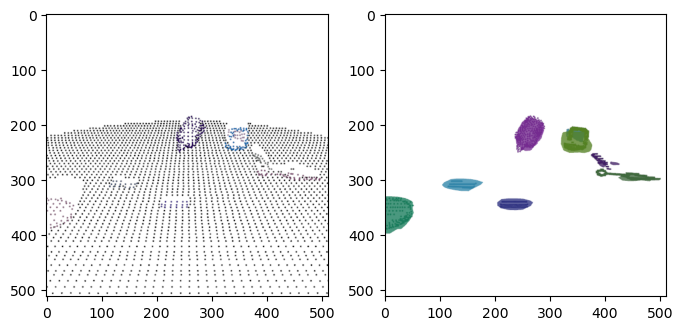

In [41]:

idx = 0
scene = dataset[idx]
scene_img = get_scene_pc_image(scene)
recon_img = reconstruct_for_scene(scene, model)

display_imgs_in_line([scene_img, recon_img])
# display_imgs_in_line([scene_img])


